## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 4 (30 pkt.)

## Wprowadzenie do Zadania 1

Zadanie będzie polegało na implementacji algorytmu Deep Deterministic Policy Gradient (DDPG) dla środowiska `LunarLanderContinuous` z biblioteki OpenAI Gym (https://gym.openai.com).

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [ ]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install gym torch matplotlib numpy box2d
# W wypadku problemów z działaniem `env.render()` na macOS Big Sur uruchom również poniższą linię
#!pip install pyglet==1.5.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.4 MB/s 


In [ ]:
# Zobacz jak działają środowiska na przykładzie 1000 kroków
import gym

env = gym.make("LunarLanderContinuous-v2")

observation = env.reset()
for _ in range(1000):
    #env.render()
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    if done:
        observation = env.reset()
env.close()

In [ ]:
import gym

# `LunarLanderContinuous` to wersja środowiska `LunarLander` z ciągłymi akcjami
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji w obu wersjach:
env_dis = gym.make("LunarLander-v2")
env_con = gym.make("LunarLanderContinuous-v2")

print("Przestrzeń stanów:", env_dis.observation_space, env_con.observation_space)
print("Rozmiar wektora reprezntującego stany:", env_dis.observation_space.shape, env_con.observation_space.shape)
print("Przestrzeń akcji:", env_dis.action_space, env_con.action_space)
# Jak widać, przestrzeń akcji zmieniła się z dyskretnej o wielkości 4 na wektor 2 liczb z zakresu od -1 do 1

Przestrzeń stanów: Box(-inf, inf, (8,), float32) Box(-inf, inf, (8,), float32)
Rozmiar wektora reprezntującego stany: (8,) (8,)
Przestrzeń akcji: Discrete(4) Box(-1.0, 1.0, (2,), float32)


### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej (identyczna jak w `homework-2-qlearning.ipynb`). Powinna ona implementować dwie metody: 1) `process_transition`, która będzie wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny. 2) `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziesz też funkcję `run_agent_in_env` (również jest taka sama jak w `homework-2-qlearning.ipynb`), która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [ ]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()

    def get_action(self, observation, learning):
        raise NotImplementedError()

In [ ]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards):
    plt.figure(figsize=(14,6))
    plt.plot(rewards)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000):
    rewards = []
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)

            # Wykonajmy akcje
            next_observation, reward, done, _ = env.step(action)
            total_reward += reward

            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)

            observation = next_observation
        rewards.append(total_reward)

        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards)
    return rewards

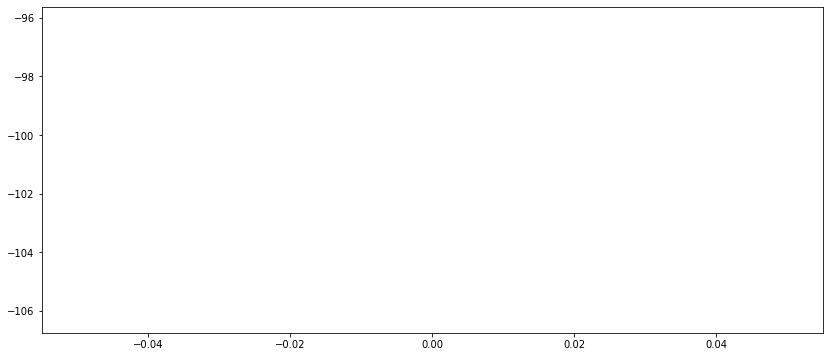

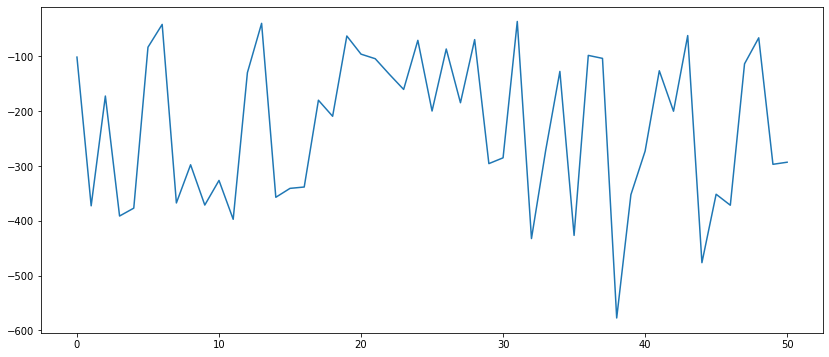

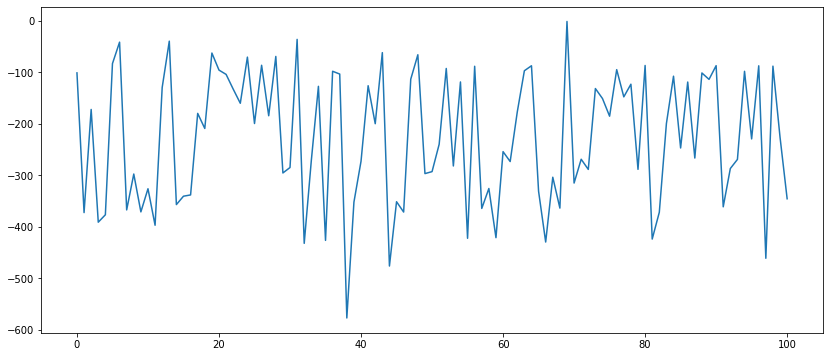

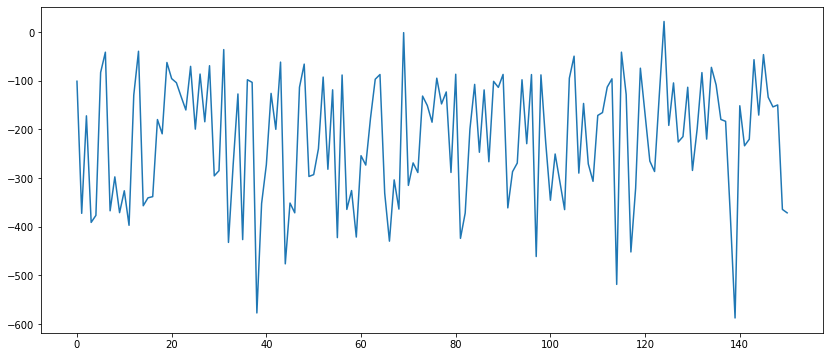

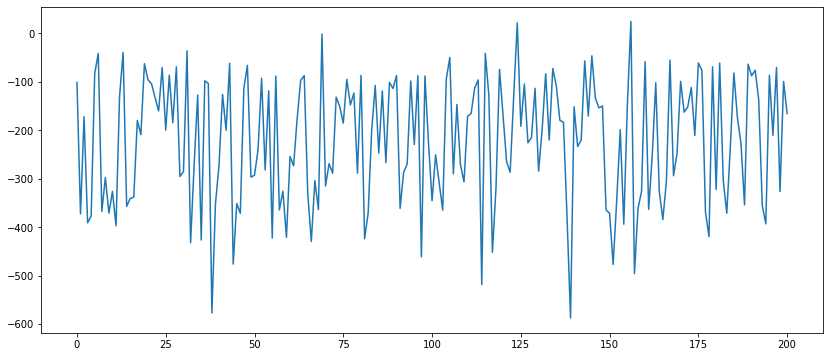

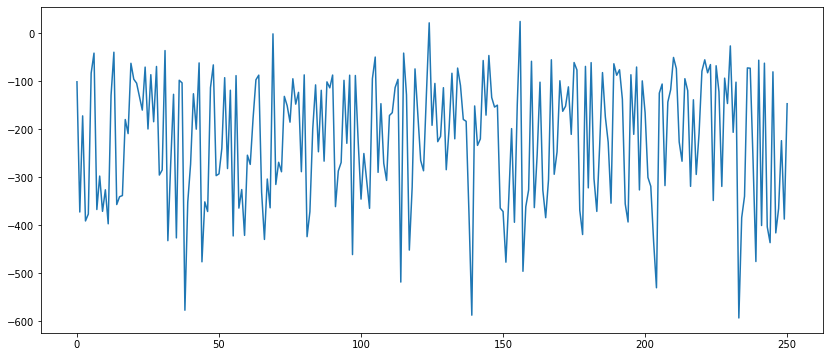

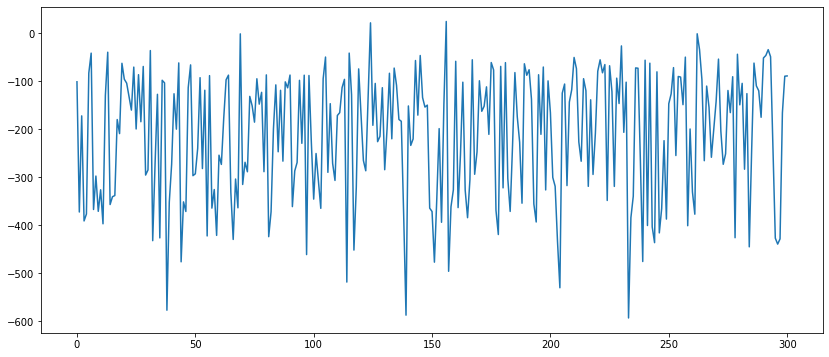

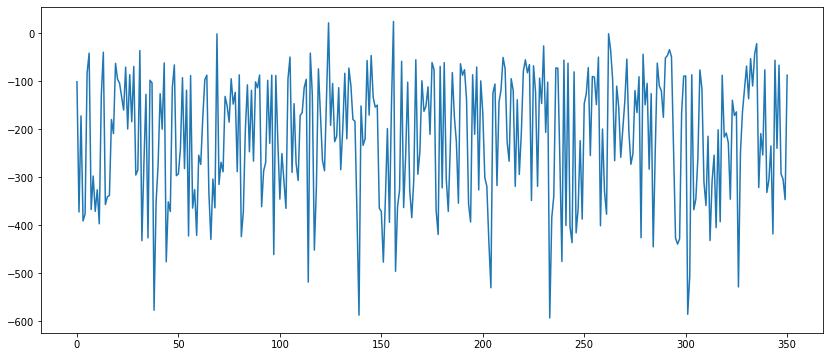

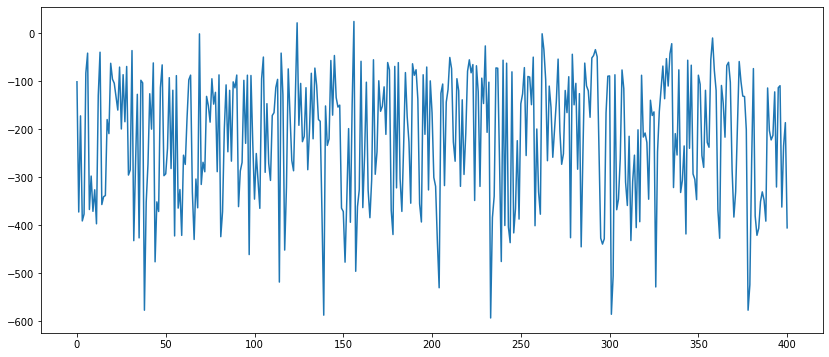

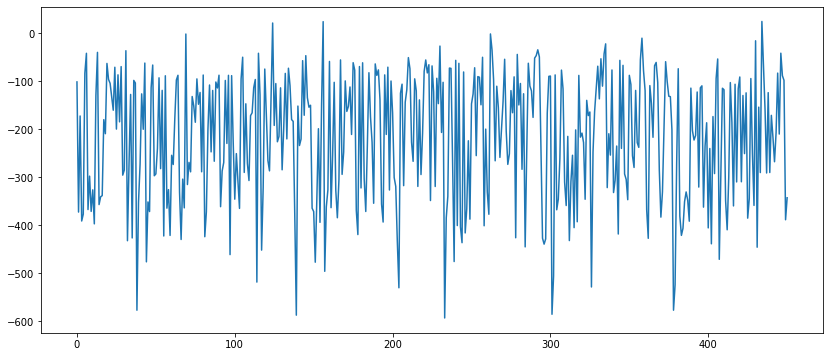

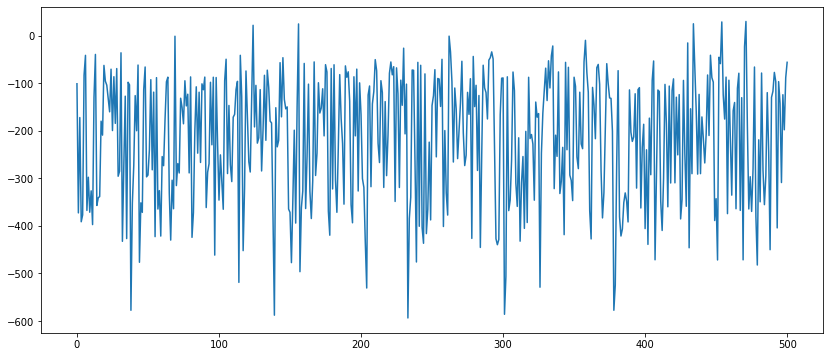

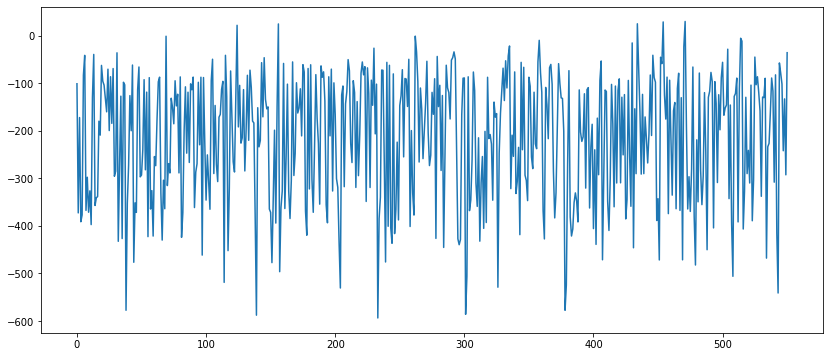

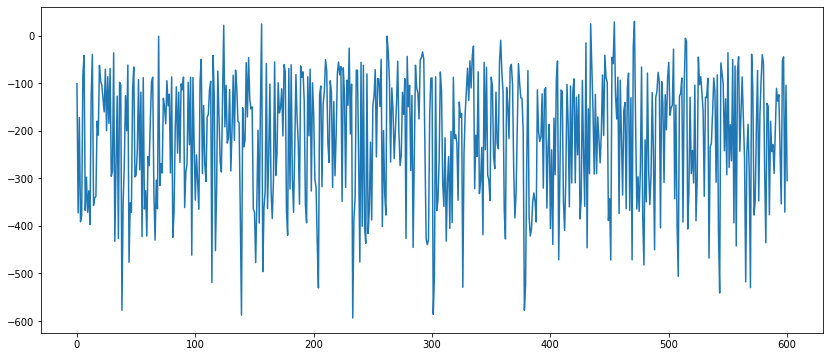

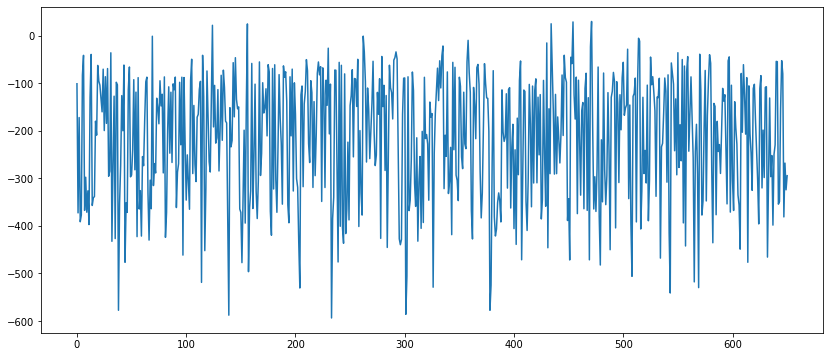

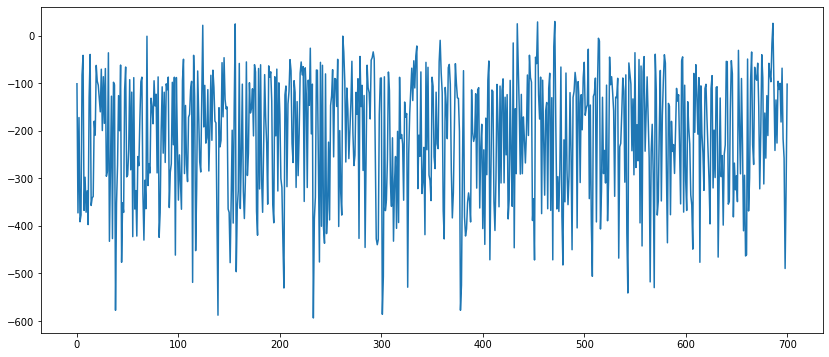

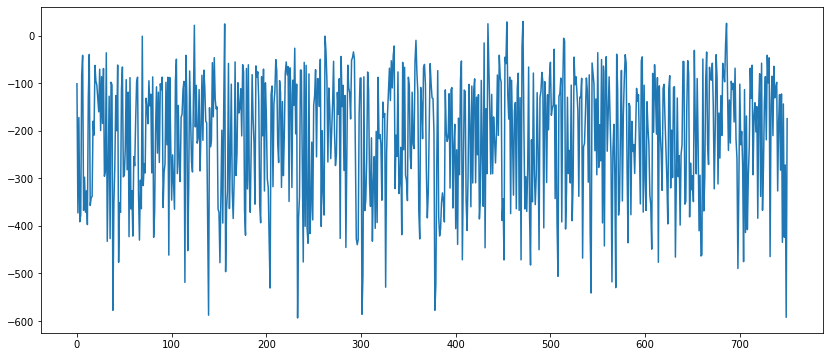

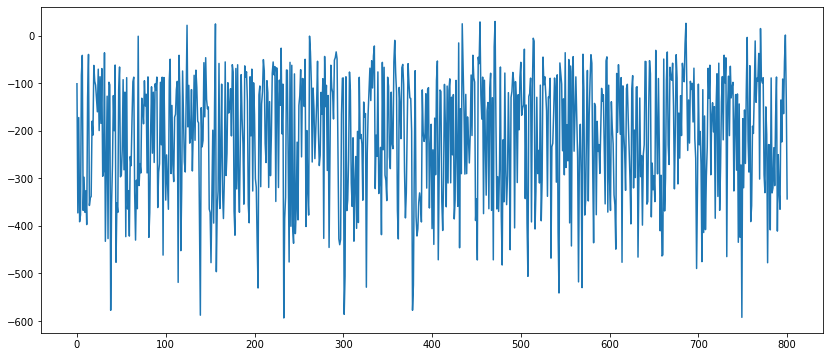

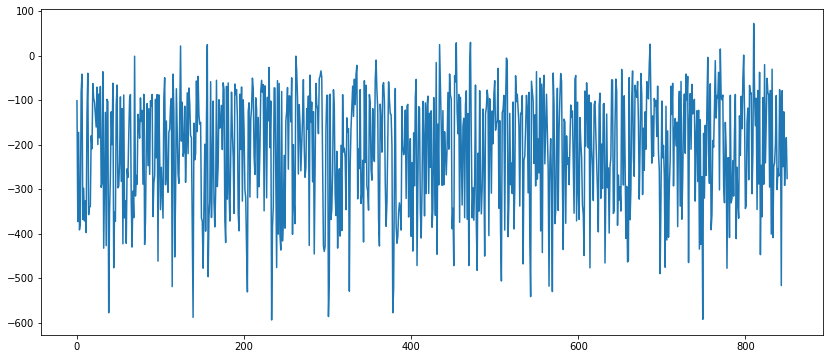

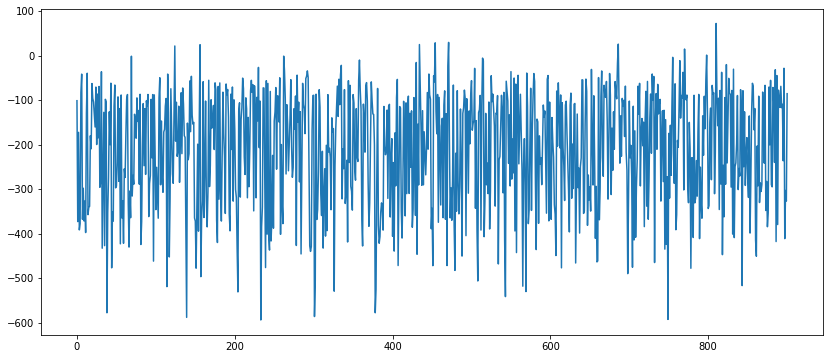

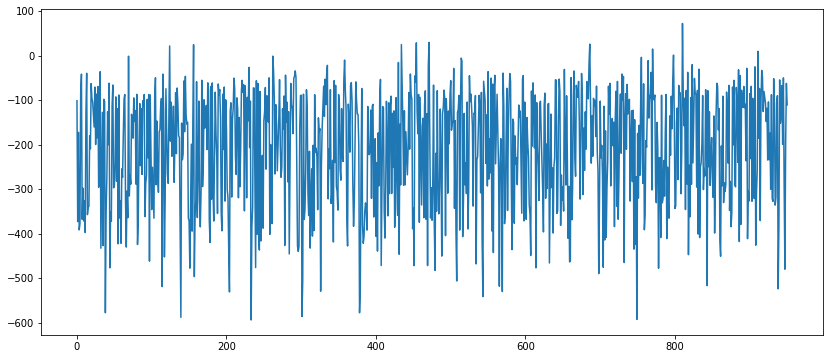

In [ ]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("LunarLanderContinuous-v2")

class RandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)

    def process_transition(self, observation, action, reward, next_observation, done):
        pass

    def get_action(self, observation, learning):
        return self.action_space.sample()

random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 1000, plot=True, plot_interval=50)

## Zad 4.1 - Deep Deterministic Policy Gradient (10pkt)

W komórkach poniżej zaimplementuj Deep Deterministic Policy Gradient dla środowiska `LunarLanderContinuous` z eksploracją opartą o dodawanie szumu Gaussowskiego, a jako aproksymatorów użyj prostych sieci neuronowych zaimplementowanych z wykorzystaniem biblioteki PyTroch.

Uwagi:
- Dobra polityka powina mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj by domyślnie Twoja implemnetacja działałą na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architektuę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.

#### Uwaga: nie zmieniaj nazwy klasy `DDPGAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komórki z klasą innego kodu.

In [ ]:
import torch as T
import torch.nn.functional as F
import numpy as np
from copy import deepcopy
device=T.device('cuda:0')
rng =np.random.default_rng()
class Q(T.nn.Module):
    def __init__(self, layers):
        super().__init__()
        model = T.nn.Sequential()
        n = len(layers)
        for i in range(1, n):
            model.add_module(f'Linear{i}', T.nn.Linear(layers[i-1], layers[i]))
            if i < n - 1:
                model.add_module(f'Activation{i}', T.nn.ReLU())

        self.model = model

    def forward(self, x):
        x = x.float()
        return self.model(x)

In [ ]:
class DDPGAgent(Agent):
    def __init__(self, env, y=0.99,epsilon=1, min_epsilon=0.1, epsilon_decay=0.999,  alpha_decay=0.999, learning_rate=0.0001,
                 min_alpha=0.01, use_memory=True, size=64,hidden=[128, 128],q_learnin=True,network_freezing=True, memory_length=1_000_000):
        super().__init__(env)
        self.y = y
        self.eps, self.min_epsilon, self.epsilon_decay = epsilon ,min_epsilon, epsilon_decay
        self.Q_policy = Q([env.observation_space.shape[0], *hidden, self.action_space.n])
        self.Q_target = deepcopy(self.Q_policy)
        self.episode=0
        self.count=0
        self.use_memory=use_memory
        self.size=size
        self.q_learnin=q_learnin
        self.network_freezing=network_freezing
        self.synchronisation_f=20
        self.loss = T.nn.MSELoss()
        self.optim = T.optim.Adam(self.Q_policy.parameters(), lr=learning_rate, weight_decay=0.00001)

        #network freezing
        self.m_idx, self.m_current_length, self.m_max_length = 0, 0, memory_length
        self.m_A, self.m_R = T.zeros((2, memory_length))
        self.m_S, self.m_S_next = T.zeros((2, memory_length, env.observation_space.shape[0]))
        self.m_S_term = T.zeros(memory_length).bool()

        #double q-learning
        model = T.nn.Sequential()
        n = ([env.observation_space.shape[0], *hidden, self.action_space.n])
        for i in range(1, 3):
            model.add_module(f'Linear{i}', T.nn.Linear(n[i-1], n[i]))
            if i < len(n) - 1:
                model.add_module(f'Activation{i}', T.nn.ReLU())
        self.model = model

    def process_transition(self, observation, action, reward, next_observation, done):
        self.count+=1
        self.m_A[self.m_idx], self.m_R[self.m_idx], self.m_S[self.m_idx], self.m_S_next[self.m_idx], self.m_S_term[self.m_idx] = action, reward, T.tensor(observation), T.tensor(next_observation), T.tensor(done).bool()
        self.m_current_length = min(self.m_current_length + 1, self.m_max_length)
        self.m_idx = (self.m_idx + 1) % self.m_max_length
        if not self.use_memory:
            i, j = self.m_idx - 1, self.m_idx
            self.m_idx -= 1
            self.m_A[i:j], self.m_R[i:j], self.m_S[i:j], self.m_S_next[i:j], self.m_S_term[i:j]
        else:
            if self.m_current_length  < (self.size+self.count//64): return
            m = T.randperm(self.m_current_length)[:self.size]
            self.m_A[m], self.m_R[m], self.m_S[m], self.m_S_next[m], self.m_S_term[m]

        if self.q_learnin:
            a_next = self.Q_policy(self.m_S_next[m]).argmax(1).long().unsqueeze(1)
            q = self.Q_target(self.m_S_next[m]).gather(1, a_next).reshape(-1)
        else:
            q = self.Q_target(self.m_S_next[m]).max(1).values

        y = (self.m_R[m] + self.y*q) * ~self.m_S_term[m]
        Y = self.Q_policy(self.m_S[m]).gather(1, self.m_A[m].long().unsqueeze(1)).reshape(-1)

        loss = self.loss(y, Y)
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        if done:
            self.eps = max(self.min_epsilon, self.eps * self.epsilon_decay)
            self.episode += 1

        if self.network_freezing and self.count % self.synchronisation_f == 0:
            self.Q_target.load_state_dict(self.Q_policy.state_dict())

    def get_action(self, observation, learning):
        if learning and np.random.rand() < self.eps:
            return np.random.randint(self.action_space.n)
        with T.no_grad():
            s = T.tensor(observation).unsqueeze(0)
            a = self.Q_policy(s).argmax()
            return int(a)

In [ ]:
# Uczenie/testowania agenta
env = gym.make("LunarLanderContinuous-v2")
agent = DDPGAgent(env)
rewards = run_agent_in_env(env, agent, 10000, learning=True, plot=True, plot_interval=250)

AttributeError: ignored

## Wprowadzenie do Zadania 4.2

Zadanie będzie polegało na implementacji algorytmu Monte Carlo Tree Search (MCTS) dla środowiska `Connect Four` z biblioteki DeepMind OpenSpiel (https://github.com/deepmind/open_spiel).

In [ ]:
# Zainstaluj bibliotekę DeepMind OpenSpiel (tylko Linux i MacOS)
!pip install open_spiel

### Środowisko `Connect Four`

Poniższy kod demonstruje działanie środowiska `Connect Four` (https://en.wikipedia.org/wiki/Connect_Four), gry dla dwóch graczy, deterministycznej z pełną informacją.

In [ ]:
# Zobacz jak działają środowisko na przykładzie jednej gry
import random
import pyspiel
import numpy as np

game = pyspiel.load_game("connect_four")
state = game.new_initial_state()

while not state.is_terminal():
    print('Tura gracza:', state.current_player())
    print('Ruch:', state.move_number())
    print('Stan:'),
    print(state.observation_string())
    print('Dopuszczalne akcje:', state.legal_actions())
    a = np.random.choice(state.legal_actions()) # Wybieramy losową z dopuszczalnych akcji
    print('Wybrana akcja:', a)
    state.apply_action(a) # Stosujemy akcję
    print('-------')
print('Koniec gry, wyniki:', state.player_reward(0), ':', state.player_reward(1)) # albo state.rewards()

In [ ]:
# Obiekt State zawiera kilka innych przydatnych metod i pól
[a for a in dir(state) if '__' not in a]

In [ ]:
# Np. historię akcji:
[(a.player, a.action) for a in state.full_history()]

In [ ]:
# Albo klonowanie stanu
state.clone()

In [ ]:
# Rozegraj grę z gotową implementacją MCTS,
# Ty zawsze zaczynasz (masz przewagę, rozpoczynający optymalny gracz zawsze powinien wygrać)
from math import sqrt
from open_spiel.python.algorithms import mcts

game = pyspiel.load_game("connect_four")
state = game.new_initial_state()

# Drugi argument MCTSBot to paramter c w UCB, trzeci argument to liczba symulacji,
# im mniej symulacji tym większa szansa, że bot wykona słaby ruch,
# sprawdz czy jesteś w stanie wygrać z botem o 10, 100, 1000 symulacjach na ruch
bot = mcts.MCTSBot(game, sqrt(2), 1000, mcts.RandomRolloutEvaluator())

while not state.is_terminal():
    if(state.current_player() == 1):
        a = bot.step(state)
    else:
        print('Tura gracza:', state.current_player())
        print('Ruch:', state.move_number())
        print('Stan:')
        print(state.observation_string())
        print('Dopuszczalne akcje:', state.legal_actions())
        a = int(input())
    state.apply_action(a)
print('Koniec gry, wyniki:', state.player_reward(0), ':', state.player_reward(1)) # albo state.rewards()

### Interface agenta

Implementacja zadania będzie się opierać o klasę `OpenSpielAgent` przedstawioną poniżej. Powinna ona implementować jedną metodę `step`, która będzie na podstawie otrzymanego stanu zwracać akcję.

Poniżej znajdziesz też funkcję `play_games`, która korzysta z opisanego wyżej obiektu agenta w celu jego ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu sumy nagród z minionych epizodów (gier), który uaktualnia się co ich zadaną liczbę.

In [ ]:
class OpenSpielAgent:
    def __init__(self, game):
        self.game = game

    def step(self, state):
        raise NotImplementedError()

In [ ]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards):
    plt.figure(figsize=(14,6))
    for r in rewards:
        plt.plot(r)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def play_game(game, agents, episodes, plot=False, plot_interval=1000):
    assert len(agents) == game.num_players()
    rewards_history = [[0] for _ in agents]
    for episode in range(episodes):
        state = game.new_initial_state()
        while not state.is_terminal():

            # Wyznaczmy aktualnego gracza (to, który agent jest, którym graczem zależy od numeru epizodu)
            p = (state.current_player() + episode) % game.num_players()

            # Zapytajmy agenta o akcje dla aktualnego stanu
            # (agent dostaje kopię stanu, by nie mógł manipulować prawdziwym przebiegiem rozgrywki)
            a = agents[p].step(state.clone())

            # Wykonajmy akcje
            # (jeśli agent zwróci niedozwoloną akcję, zostanie wykonana losowa akcja)
            try:
                state.apply_action(a)
            except:
                print("Agent selected inlegal action, using random action instead")
                state.apply_action(np.random.choice(state.legal_actions()))

        for i in range(game.num_players()):
            p = (i + episode) % game.num_players()
            rewards_history[i].append(rewards_history[i][-1] + state.player_reward(p))

        # Wyświetl na wykresie sumę nagród z minionych epizodów
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards_history)
    return rewards_history

In [ ]:
# Demonstracja na przykładzie losowego agenta vs agenta używającego MCTS

class RandomAgent(OpenSpielAgent):
    def __init__(self, game):
        super().__init__(game)

    def step(self, state):
        return np.random.choice(state.legal_actions())


game = pyspiel.load_game("connect_four")
random_agent = RandomAgent(game)
mcts_agent = mcts.MCTSBot(game, sqrt(2), 100, mcts.RandomRolloutEvaluator())
rewards = play_game(game, (random_agent, mcts_agent), 10, plot=True, plot_interval=2)

## Zad 2 - Monte Carlo Tree Search (20pkt)

W komórkach poniżej zaimplementuj Agenta używającego Monte Carlo Tree Search dla środowiska `Connect Four`. Użyj losowej polityki rolloutu oraz polityki drzewa opartej o UCB.

Odpowiedz na pytania (bonusowe):
- Ile stanów posiada środowisko `Connect Four` (ile wierzchołków ma drzewo stanów, możesz policzyć za pomocą komutera).
- Czy widzisz jakiś sprytny sposób na mniejszenie przestrzeni stanów dla gry `Connect Four`? (nie implemnetuj jej).

Uwagi:
- Zadbaj o to by wybór ruch przez Twojego agenta nie trwał dłużej niż 1-2 sekundy.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Agent powinen wygrywać albo remisować większość gier, które rozpoczyna przeciwko innemu silnemu graczowi (np. gotowemu botowi MCTS).

#### Uwaga: nie zmieniaj nazwy klasy `MCTSAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Miejsce na Twoje odpowiedzi

In [ ]:
import math
class State:
    __slots__ = 'state player parent action visits value children unexpanded'.split()
    def __init__(self, *, state, player, parent=None, children=[], val=0, visits=0, action=None):
        self.state= state
        self.player =  player
        self.visits = visits
        self.children = children
        self.parent = parent
        self.value = val
        self.action = action
        self.unexpanded = state.legal_actions().copy()

    def apply(self, action):
        S_clone = self.state.clone()
        S_clone.apply_action(action)
        return State(state=S_clone, parent=self, action=action, player=1-self.player)

    def best_child(self):
        return max(self.children, key=lambda x:  sqrt(2*math.log(self.visits)/x.visits)-x.value/x.visits)



In [ ]:
import time

class MCTSAgent(OpenSpielAgent):
    def __init__(self, game,time_limit=2,iter_limit=40_000):
        super().__init__(game)
        self.time_limit,self.iter_limit=time_limit,iter_limit

    def step(self, state):
        t = time.time()
        iter=0
        s_start = State(state=state, player=state.current_player())
        while time.time()-t <self.time_limit:
          iter+=1
          if iter>self.iter_limit:
            break
          S=s_start
          while S.children and not S.unexpanded:
            S=S.best_child()

          if S.unexpanded:
            S_next = S.apply(S.unexpanded.pop(np.random.default_rng().integers(len(S.unexpanded))))
            S.children.append(S_next)
            S = S_next
          #3
          S_clone=S.state.clone()
          while not S_clone.is_terminal():
            #S=S.best_child()
            S_clone.apply_action(rng.choice(S_clone.legal_actions()))
          #4
          while S is not None:
                S.value += S_clone.player_reward(S.player)
                S.visits += 1
                S = S.parent

        return max(s_start.children, key=lambda x: x.visits).action



In [ ]:
# Testowania agenta
from open_spiel.python.algorithms import mcts
game = pyspiel.load_game("connect_four")
agent = MCTSAgent(game)
mcts_agent = mcts.MCTSBot(game, sqrt(2), 100, mcts.RandomRolloutEvaluator())
play_game(game, (agent, mcts_agent), 100, plot=True, plot_interval=10)